In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import glob
import pandas as pd
import numpy as np
import py2edw
import datetime as dt
import time

import operator

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.cm as cm
import seaborn as sns

# Read in Data

In [3]:
path = r'C:\Users\wkong\Desktop\Work\customer_segmentation\data\clean'
files = glob.glob(path + '/*.csv')

In [4]:
data = pd.read_csv(os.path.join(path,'prepped_customer_data.csv'))
data.set_index('customer_id', inplace=True)

# Scale Data

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# PCA

In [59]:
def plot_pca_2d(X_scaled):
    pca = PCA(n_components=X_scaled.shape[1], svd_solver='full')
    X_r = pca.fit_transform(X_scaled)
    print(pca.explained_variance_ratio_.cumsum())  
    for i in range(1,X_scaled.shape[1]):
        plt.figure()
        plt.scatter(X_r[:,0], X_r[:,i])
        plt.xlabel(0)
        plt.ylabel(i)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

[0.2284605  0.2893555  0.34382091 0.39476022 0.43490012 0.47336997
 0.50902827 0.54393445 0.57858124 0.61295025 0.64680443 0.68018976
 0.71259298 0.74354075 0.77250861 0.79802764 0.82239615 0.8442303
 0.86501432 0.88359106 0.90179775 0.91936953 0.93643075 0.95107138
 0.96453712 0.97538785 0.98470915 0.99278416 1.        ]


C:\Users\wkong\AppData\Roaming\Python\Python36\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


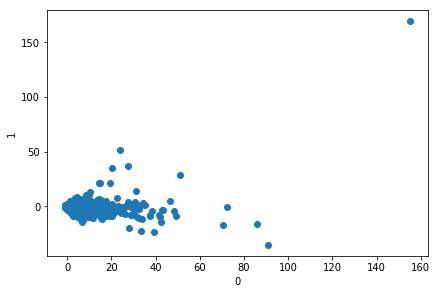

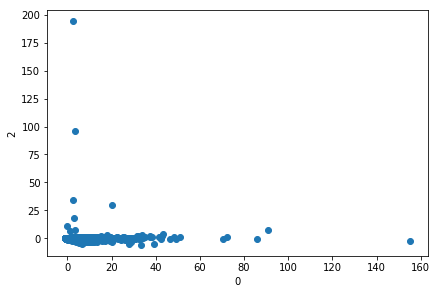

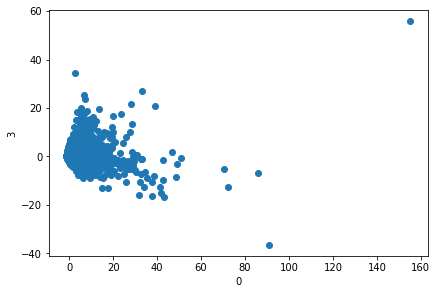

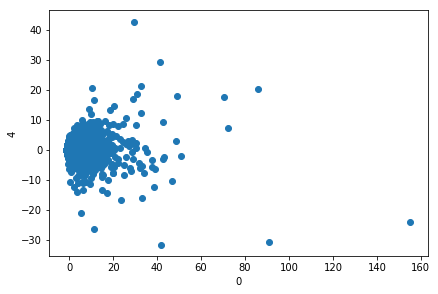

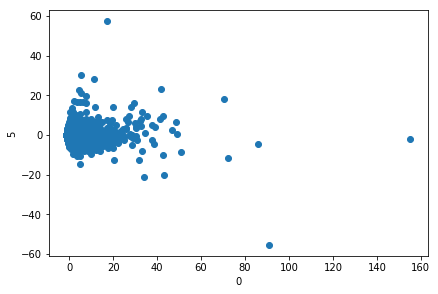

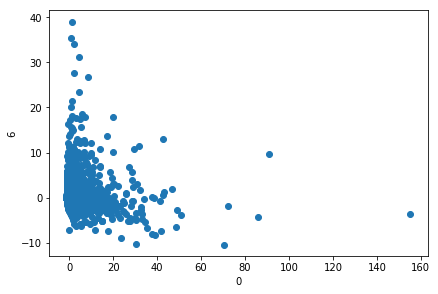

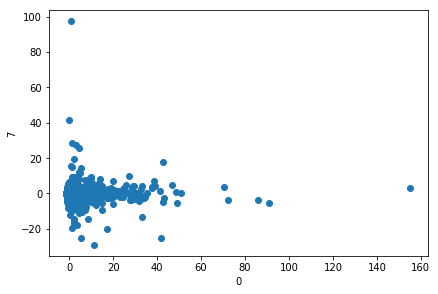

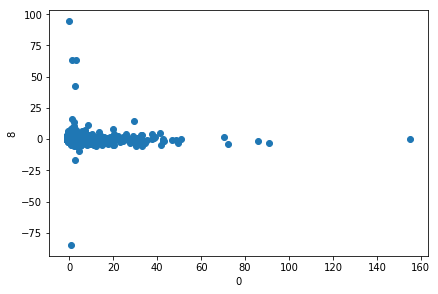

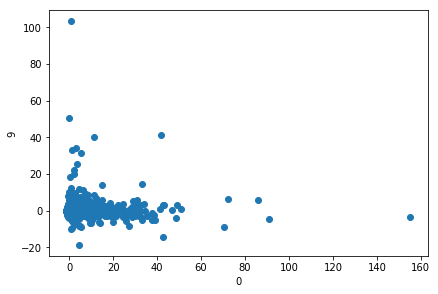

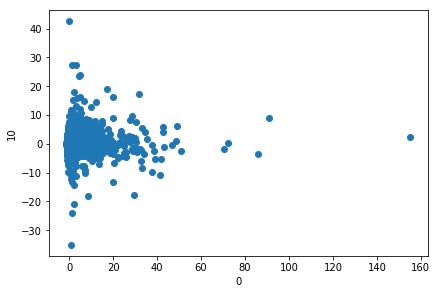

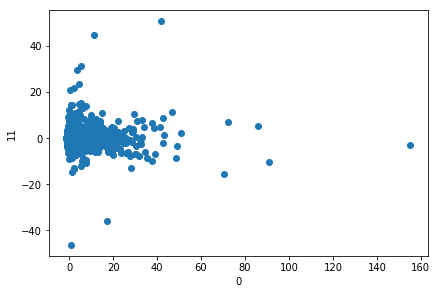

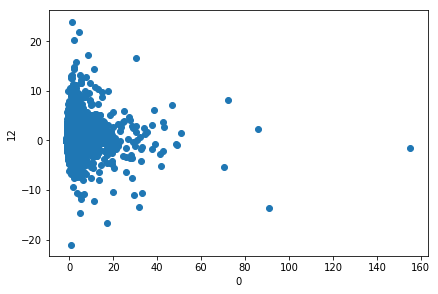

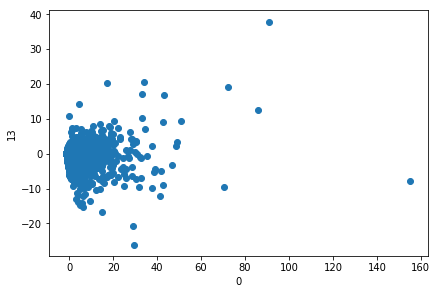

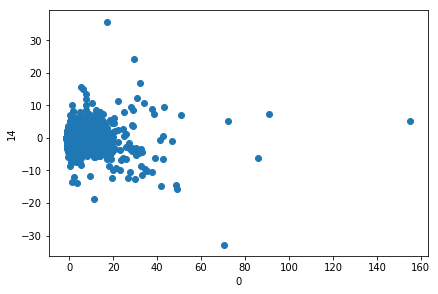

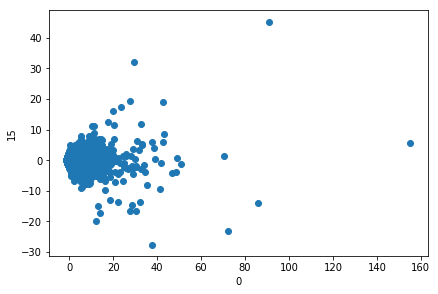

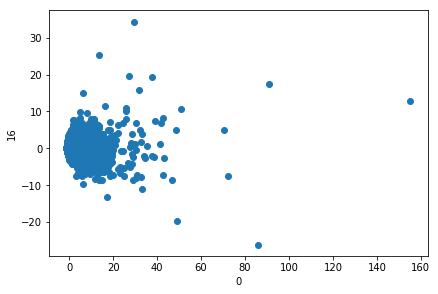

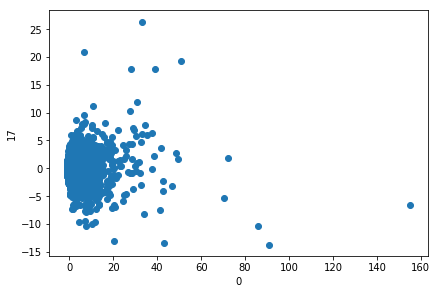

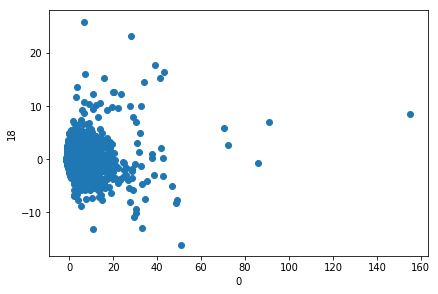

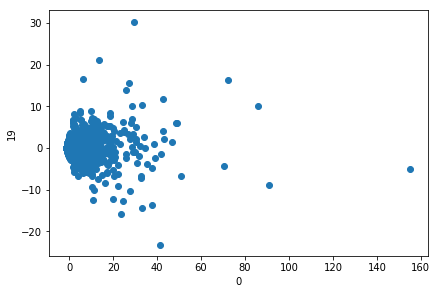

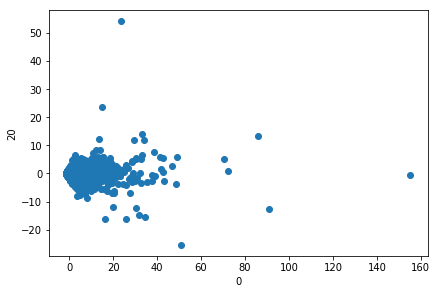

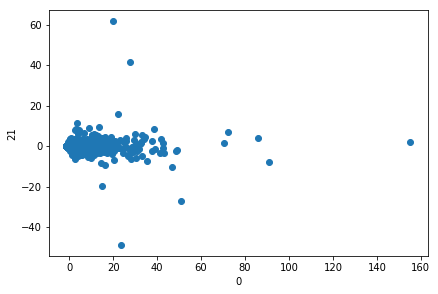

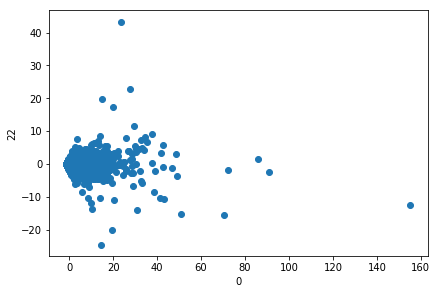

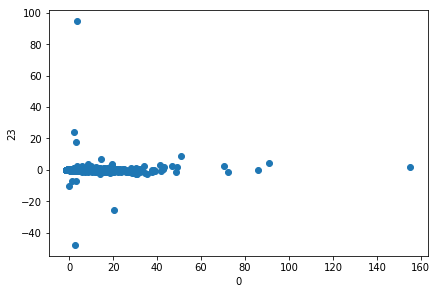

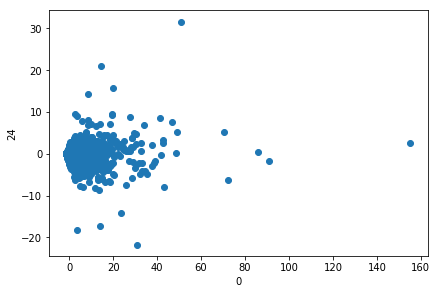

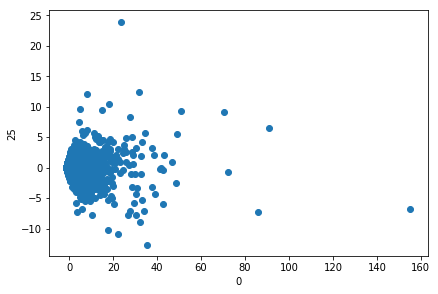

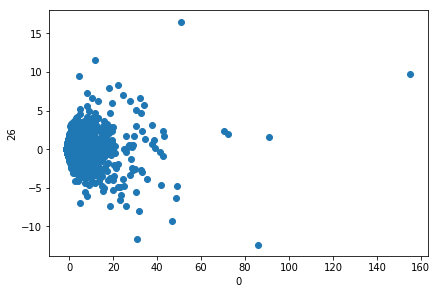

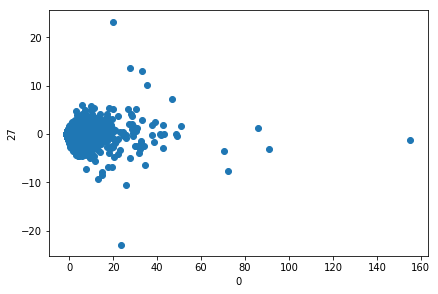

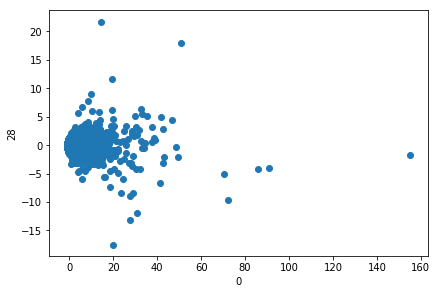

In [60]:
plot_pca_2d(X_scaled)

In [61]:
def plot_pca_3d(X_scaled):
    pca = PCA(n_components=X_scaled.shape[1], svd_solver='full')
    X_r = pca.fit_transform(X_scaled)
    print(pca.explained_variance_ratio_.cumsum()) 
    for i in range(X_scaled.shape[1]-2):
        plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(X_r[:,i], X_r[:,i+1], X_r[:,i+2])
        plt.xlabel(i)
        plt.ylabel(i+1)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

[0.2284605  0.2893555  0.34382091 0.39476022 0.43490012 0.47336997
 0.50902827 0.54393445 0.57858124 0.61295025 0.64680443 0.68018976
 0.71259298 0.74354075 0.77250861 0.79802764 0.82239615 0.8442303
 0.86501432 0.88359106 0.90179775 0.91936953 0.93643075 0.95107138
 0.96453712 0.97538785 0.98470915 0.99278416 1.        ]


C:\Users\wkong\AppData\Roaming\Python\Python36\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


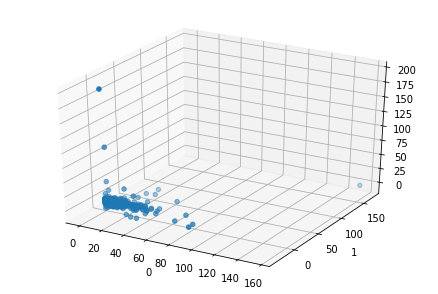

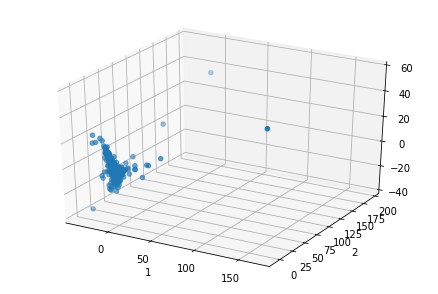

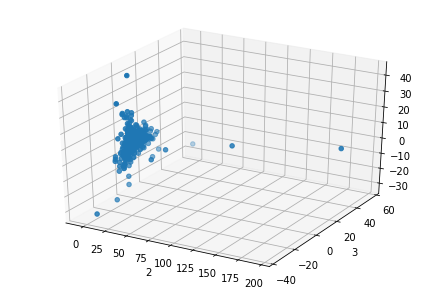

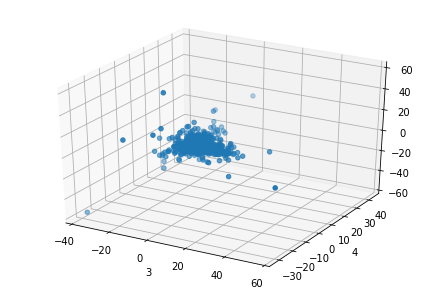

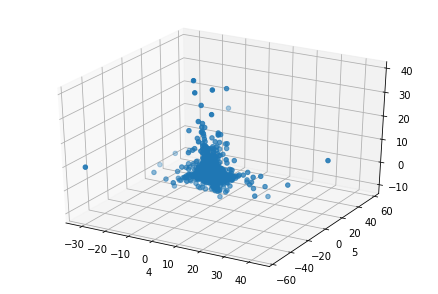

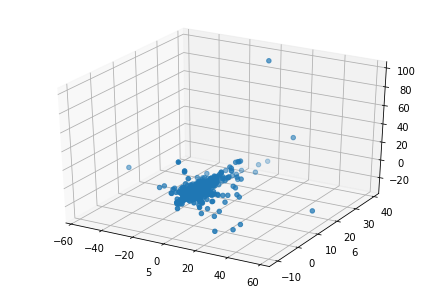

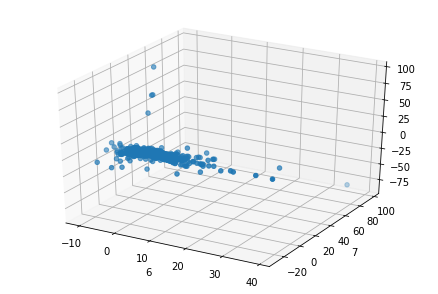

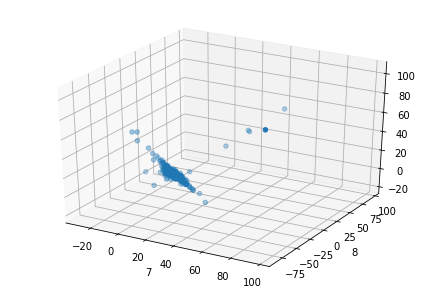

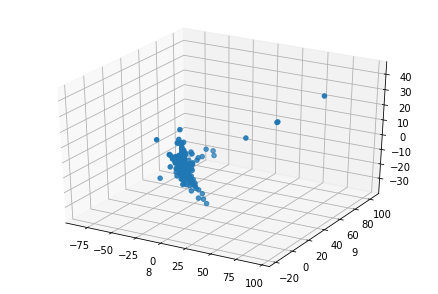

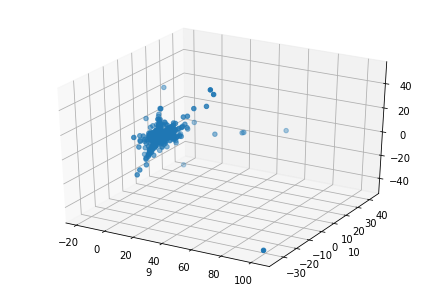

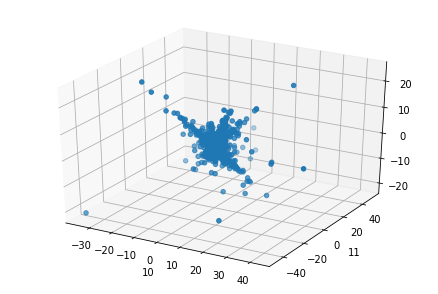

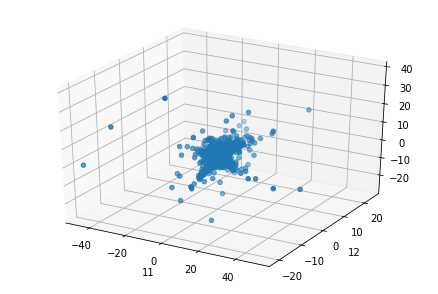

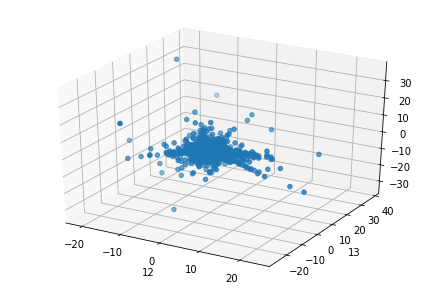

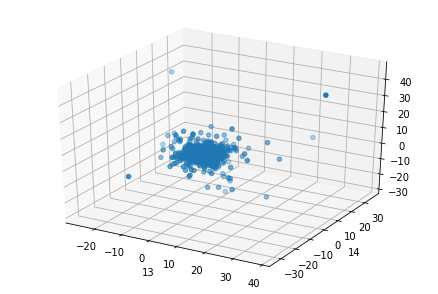

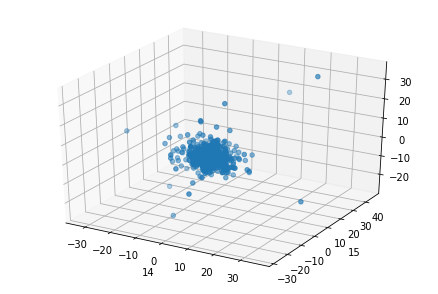

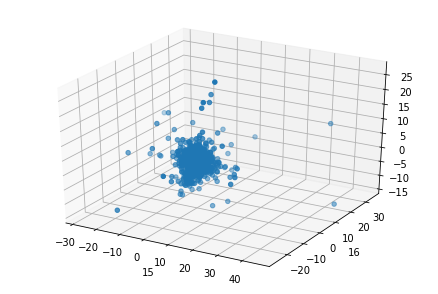

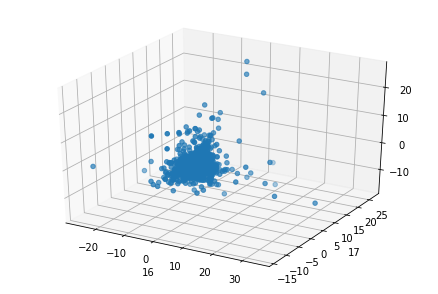

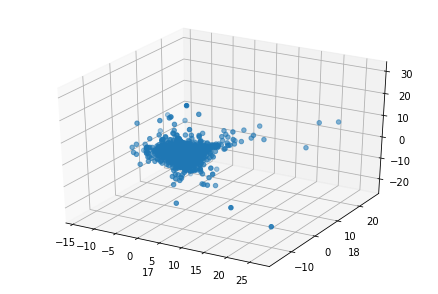

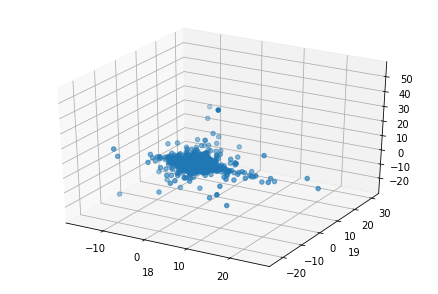

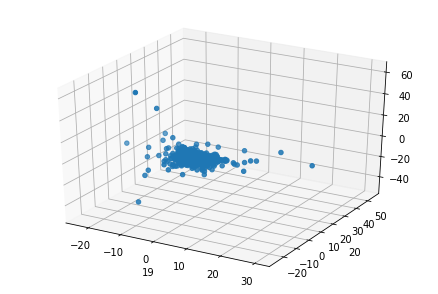

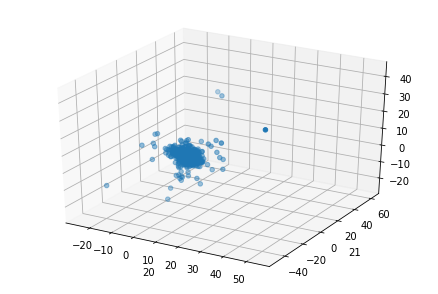

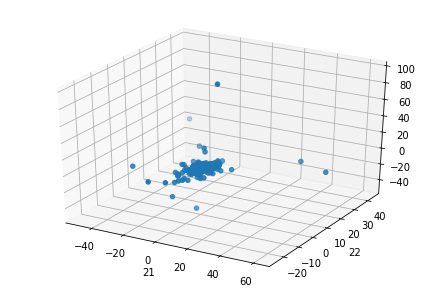

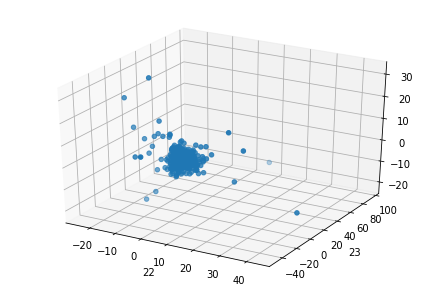

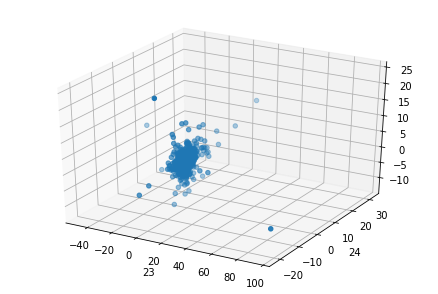

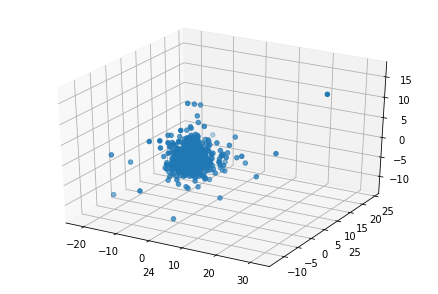

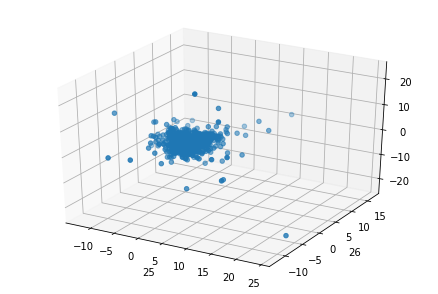

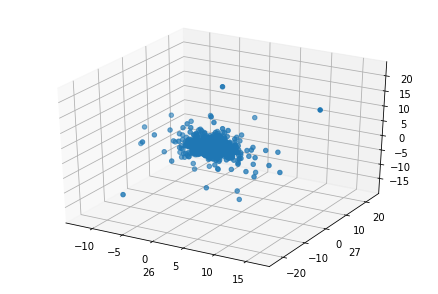

In [62]:
plot_pca_3d(X_scaled)

# KMeans

In [41]:
def plot_kmeans(data,labels,fname):
    unique_labels = set(labels)
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
    
    fig = plt.figure(figsize=(22,20))
    plt.subplots_adjust(hspace=0.2)
    ctr=0
    for i in range(len(data[0])-1):
        ax = fig.add_subplot(7, 3, i+1) 
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]
            class_member_mask = (labels == k)

            xy = pd.DataFrame(data[class_member_mask])
            
            plt.plot(xy.iloc[:, i], xy.iloc[:, i+1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14, label=k)    
            
            plt.xlabel('PCA{}'.format(i),labelpad=10)
            plt.ylabel('PCA{}'.format(i+1))
            plt.tight_layout()
            
    plt.legend(ncol=15, loc='lower center', bbox_to_anchor=(0.5, -0.5))

    plt.savefig("{}.jpg".format(fname),  format='jpg', dpi=200)

        

In [6]:
from sklearn.cluster import MiniBatchKMeans

In [7]:
kdata = PCA(n_components=21, svd_solver='full').fit_transform(X_scaled)

In [8]:
klabels = MiniBatchKMeans(n_clusters=6).fit_predict(kdata)

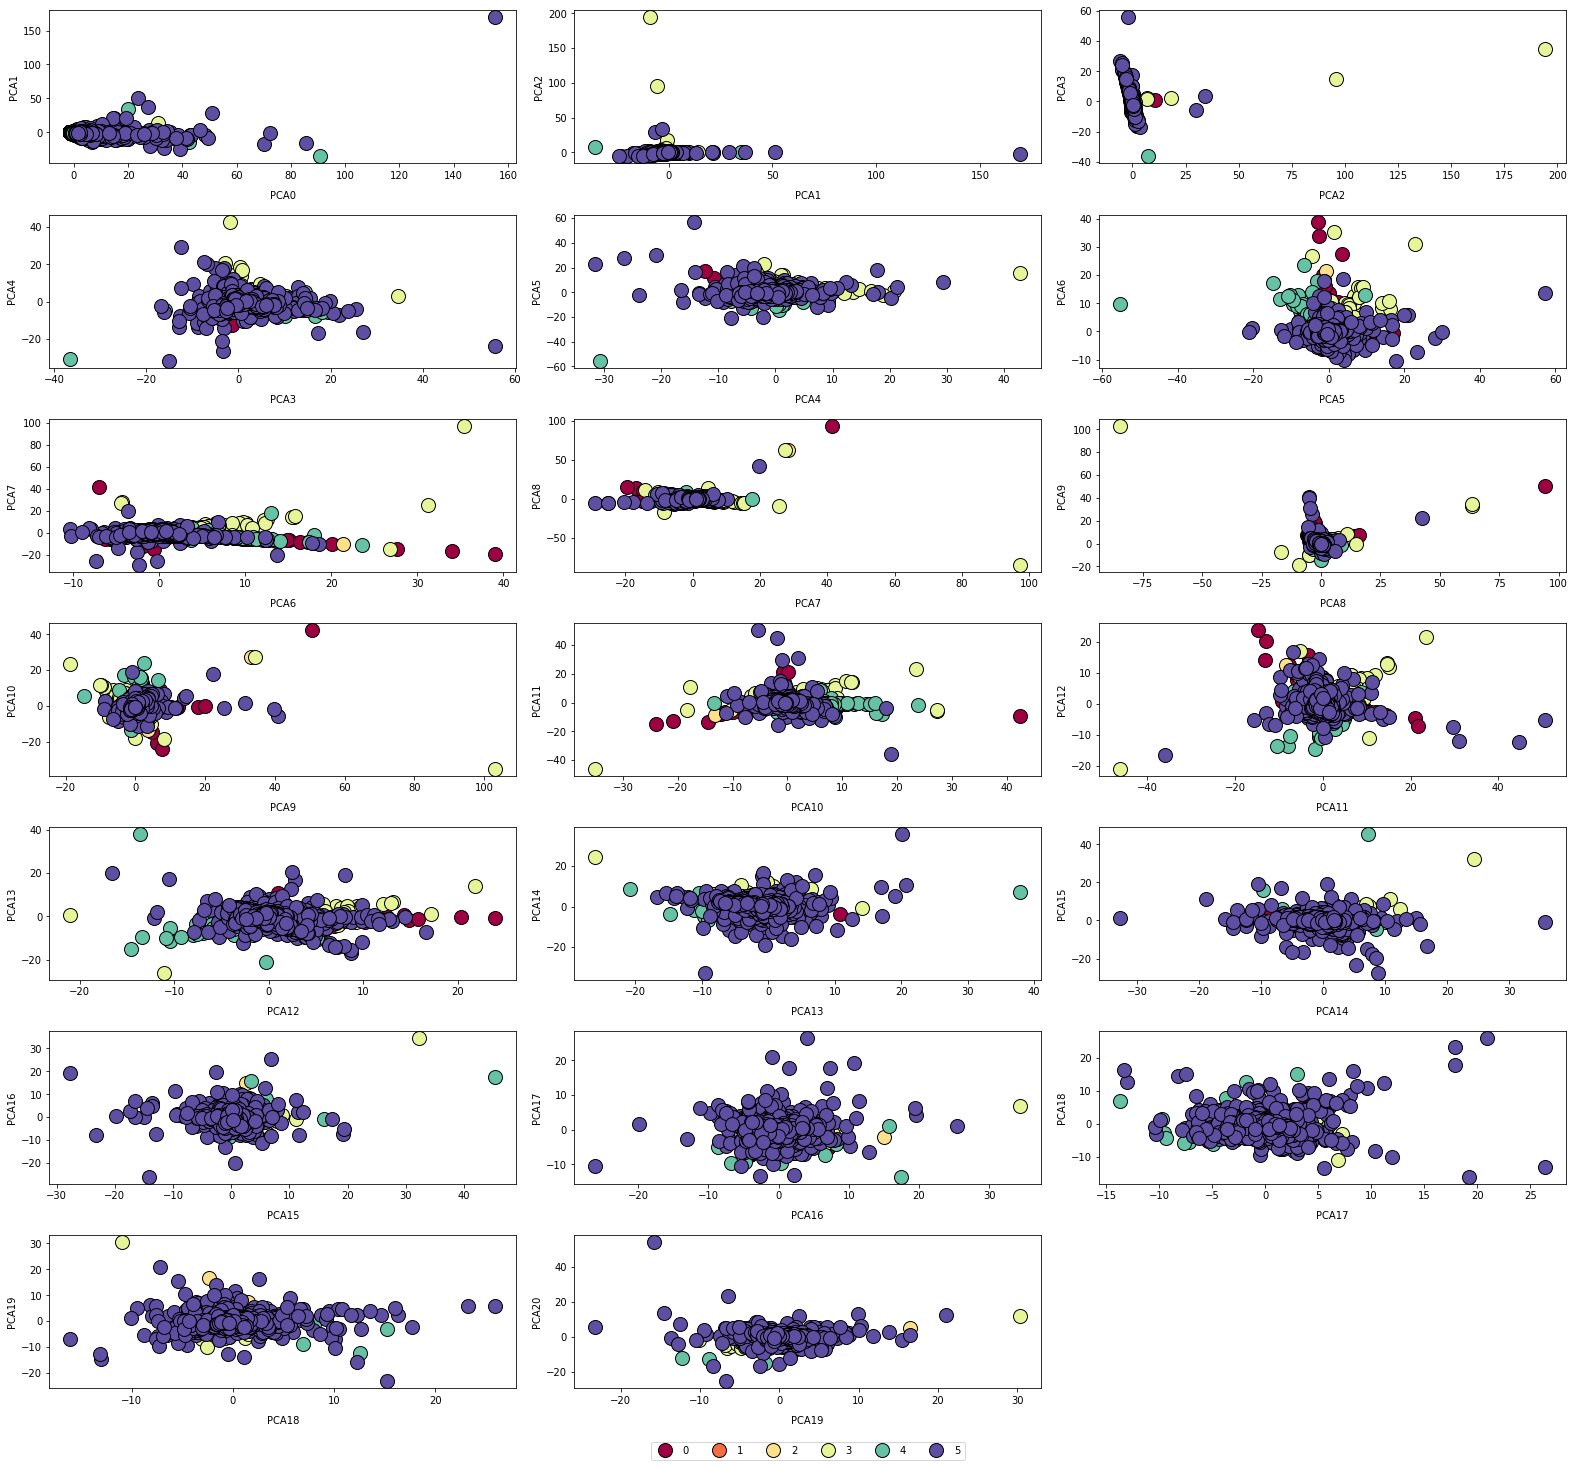

In [42]:
plot_kmeans(kdata, klabels, 'kmeans')

In [90]:
data_df = pd.DataFrame(data)
klabels_df = pd.DataFrame(klabels)
klabels_df.columns = ['labels']

In [91]:
res_df = pd.concat([data_df.reset_index(),klabels_df], axis=1)

In [92]:
res_df.to_csv('KMeans_results.csv')

# DBSCAN

In [32]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [44]:
def plot_clusters(data, labels, core_samples_mask, fname, show_outliers=False):
    unique_labels = set(labels)
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
    
    fig = plt.figure(figsize=(22,20))
    plt.subplots_adjust(hspace=0.2)
    ctr=0
    for i in range(len(data[0])-1):
        ax = fig.add_subplot(7, 3, i+1) 
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]
            class_member_mask = (labels == k)

            xy = pd.DataFrame(data[class_member_mask & core_samples_mask])
            plt.plot(xy.iloc[:, i], xy.iloc[:, i+1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14, label=k)    
            plt.xlabel(i)
            plt.ylabel(i+1)

            if show_outliers:
                xy = pd.DataFrame(data[class_member_mask & ~core_samples_mask])
                plt.plot(xy.iloc[:, i], xy.iloc[:, i+1], 'o', markerfacecolor=tuple(col),
                         markeredgecolor='k', markersize=2, label=k)
            
            plt.xlabel('PCA{}'.format(i),labelpad=10)
            plt.ylabel('PCA{}'.format(i+1))
            plt.tight_layout()
    
    plt.legend(ncol=15, loc='lower center', bbox_to_anchor=(0.5, -0.5))

    plt.savefig("{}.jpg".format(fname),  format='jpg', dpi=200)

In [30]:
dataDB = PCA(n_components=22, svd_solver='full').fit_transform(X_scaled)

In [33]:
db = DBSCAN(eps=0.2, min_samples=7).fit(dataDB)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 11


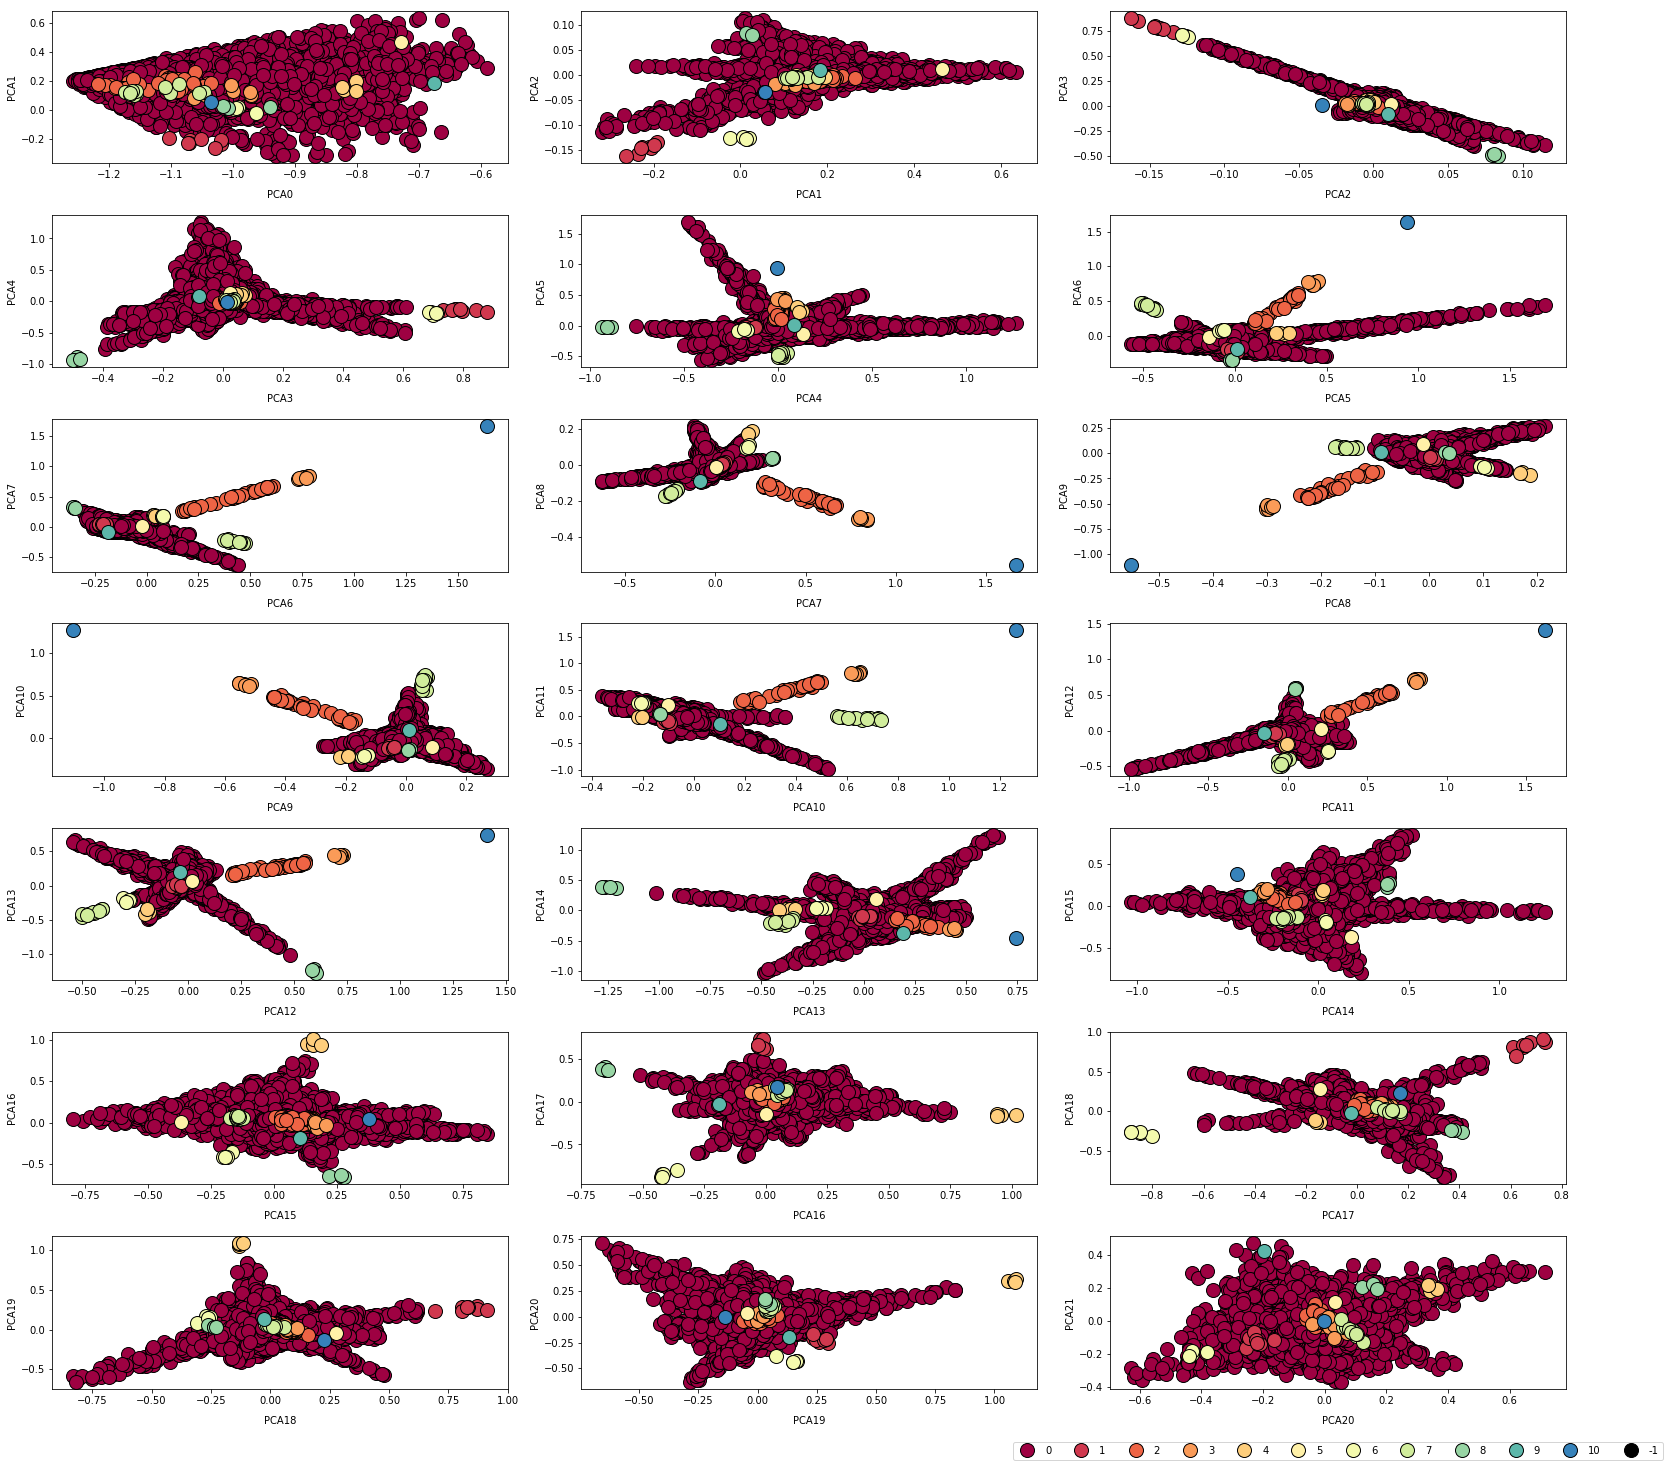

In [45]:
plot_clusters(dataDB, labels, core_samples_mask, 'DBSCAN', False)

# Save data

In [95]:
label_df = pd.DataFrame(labels)
label_df.columns = ['label']

In [96]:
pd.concat([data_df.reset_index(),label_df], axis=1).to_csv('DBSCAN_results.csv', index=False)